# Zipf it up

## Zipf's law: Given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table.
### This follows a basic power law (but with additional parameters):
$$ {\displaystyle{\displaystyle p(x)  \propto x^{\alpha}}} $$
### Zipf's law predicts that out of a population of $N$ elements, the normalized frequency of the element of rank $k$, $f(k;\alpha,N)$, is:

$${\displaystyle f(k;\alpha,N)={\frac {1/k^{\alpha}}{\sum \limits _{n=1}^{N}(1/n^{\alpha})}}}$$

#### A dataset can be tested to see whether Zipf's law applies by checking the "goodness of fit" of the dataset's observed rank frequency distribution to a hypothesized power law distribution, by using a Kolmogorov–Smirnov test.



#### This code does all that stuff.

In [1]:
# grepping the installation babbling basically just 
# suppresses the warnings by providing a command that will find them but won't print them.
!pip install powerlaw | grep -v 'Requirement already satisfied' 
import powerlaw
import pandas as pd
import numpy as np
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import hmean, norm, ks_2samp
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
data= load_dataset("oscar", "unshuffled_deduplicated_en", split = "train", streaming= True)
#data = load_dataset("c4", "en", split= "train", streaming = True)

In [3]:
# For streaming data
print('Note: Just taking the first 1000 instances.')
data_head = data.take(1000)
df = pd.DataFrame(data_head)
# If not streaming, use:
#df = pd.json_normalize(data)

Note: Just taking the first 1000 instances.


### Look at the top rows as a sanity-check

In [4]:
df.head()

,id,text
0,0,Mtendere Village was inspired by the vision of...
1,1,Lily James cannot fight the music. In the titl...
2,2,"""I'd love to help kickstart continued developm..."
3,3,"""We view 11-11 as a top-tier, strategic partne..."
4,4,Are you looking for Number the Stars (Essentia...


### Get more basic sanity-check information

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1000 non-null   int64 
 1   text    1000 non-null   object
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


### Check for missing values

In [6]:
df[df.isnull().any(axis=1)].head()
np.sum(df.isnull().any(axis=1))

0

### Count vocab size + frequencies

In [7]:
def count_vocab_frequencies(df, cutoff=3):
    """
    Based on an input pandas DataFrame with a 'text' column, 
    this function will count the occurrences of all words
    with a frequency higher than 'cutoff' and will return another DataFrame
    with the rows corresponding to the different vocabulary words
    and the column to the total count of that word.
    """
    # Move this up as a constant in larger code.
    batch_size = 10
    cvec = CountVectorizer(token_pattern=u"(?u)\\b\\w+\\b")
    # Needed to modify the minimum token length: 
    # https://stackoverflow.com/questions/33260505/countvectorizer-ignoring-i
    cvec.fit(df.text)
    document_matrix = cvec.transform(df.text)
    batches = np.linspace(0, df.shape[0], batch_size).astype(int)
    i = 0
    tf = []
    while i < len(batches) - 1:
        batch_result = np.sum(document_matrix[batches[i]:batches[i+1]].toarray(), axis=0)
        tf.append(batch_result)
        i += 1
    term_freq_df = pd.DataFrame([np.sum(tf, axis=0)], columns=cvec.get_feature_names()).transpose()
    term_freq_df.columns = ['total']
    term_freq_df = term_freq_df[term_freq_df['total'] > cutoff]
    sorted_term_freq_df = pd.DataFrame(term_freq_df.sort_values(by='total')['total'])
    return sorted_term_freq_df

In [8]:
term_df = count_vocab_frequencies(df)
print("Info on the observed frequencies:")
print(term_df.info())
print("------------------------------------")
print("Vocab size (types):\t%s" % len(term_df))
print("Vocab size (tokens):\t%s" % sum(term_df['total']))
print("Observations look like this:")
print(term_df.tail())

Info on the observed frequencies:
<class 'pandas.core.frame.DataFrame'>
Index: 16257 entries, jaws to the
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   total   16257 non-null  int64
dtypes: int64(1)
memory usage: 254.0+ KB
None
------------------------------------
Vocab size (types):	16257
Vocab size (tokens):	1005258
Observations look like this:
     total
a    22043
of   24251
to   28256
and  29384
the  50142


### Fit the observed totals to a Zipfian powerlaw.
#### Because the ranks are integers, we treat it as a discrete distribution (actually should be 'ordinal' distribution). Our reasoning is that it doesn't make sense to mandate that the distances between the ranks are equal; the values are 'ordinal' actually.
#### We fit this distribution to a power law by minimizing the Kolmogorov–Smirnov (KS) distance.
#### Our reasoning in using a KS objective rather than Maximun Likelihood Estimation (MLE) is that a fundamental assumption of MLE is that individual data points are independent, but that oughtn't be so with the use of words in language (we think)...

In [9]:
import math
# Uses the powerlaw package to fit the observed frequencies to a zipfian distribution

observed_counts = np.flip(term_df['total'].values)
# Turn these into an empirical probability distribution by normalizing by the total sum.
# Note -- doesn't seem to matter actually; can remove.
norm = float(sum(observed_counts))
#observed_probabilities = observed_counts/norm
#observed_log_probabilities = np.log(observed_counts) - np.log(norm)
# 'fit_method' is MLE by default; doesn't seem to change the results in my initial pokings.
# Also tried discrete_approximation="xmax"
# Note another method for determining alpha 
# might be defined by (Newman, 2005 for details): alpha = 1 + n * sum(ln( xi / xmin )) ^ -1
fit = powerlaw.Fit(observed_counts, fit_method="KS", discrete=True)
# bins_edges = The edges of the bins of the probability density function.
# The portion of the data that is within the bin. Length 1 less than bin_edges, as it corresponds to the spaces between them.
# .pdf() returns the probability density function (normalized histogram) of the theoretical distribution
bin_edges, observed_probabilities = fit.pdf(original_data=True)
#observed_probabilities = observed_counts/norm
# The estimated values
# power_law.pdf() returns the probability density function (normalized histogram) of the data.
predicted_probabilities = fit.power_law.pdf()
alpha = fit.power_law.alpha
xmin = fit.power_law.xmin
distance = fit.power_law.KS()

# Ditching the values returned from the Fit method and just
# calculating the pdf directly.  Revisit.
observed_probabilities = np.flip(observed_counts/norm)
predicted_probabilities = np.flip(bin_edges/norm)

# We know the optimal xmin, but now let's set the prediction xmin to a lower value
# so we can graph out more beyond the cutoff.
# Note: Bring this up as a parameter that can be set.
# fit.xmin = .001

print("------------------------------------")
print("Optimal Alpha:\t\t%.4f" % alpha)
print("Optimal Frequency cut-off:\t%s" % xmin)
print("Distance:\t\t%.4f" % distance)
# Significance testing
# Note: We may want to use bootstrapping (instead of the standard KS test p-value tables) to determine statistical significance
# See: https://stats.stackexchange.com/questions/264431/how-to-determine-if-zipfs-law-can-be-applied Answer #4
print("Checking the goodness of fit of our observed distribution")
print(" to the hypothesized power law distribution")
print(" using a Kolmogorov–Smirnov (KS) test.")
ks_test = ks_2samp(observed_probabilities, predicted_probabilities)
# print("KS test:", end='\t\t')
print(ks_test)
print("\nThe KS test p-value is: %.4f" % ks_test.pvalue)
if ks_test.pvalue < .01:
    print("\nYour data fits a powerlaw with a minimum KS distance of %.4f" % distance)
    print("\nWoohoo!")
else:
    print("\nYour data does not fits a powerlaw. =\(")
    print("\nDO BETTER.")

Calculating best minimal value for power law fit
------------------------------------
Optimal Alpha:		2.0362
Optimal Frequency cut-off:	57.0
Distance:		0.0230
Checking the goodness of fit of our observed distribution
 to the hypothesized power law distribution
 using a Kolmogorov–Smirnov (KS) test.
KstestResult(statistic=0.5921051644544864, pvalue=3.112644631622555e-14)

The KS test p-value is: 0.0000

Your data fits a powerlaw with a minimum KS distance of 0.0230

Woohoo!


### WARNING WARNING MAJOR HACKY LAND!!  
#### Taking the original ranks, corresponding to words, and calculating the corresponding probability from the fitted model at that rank.
#### Doing this basically in the slowest way possible because I was getting frustrated with fancier tools not working so I just hacked through inelegantly.

In [10]:
from collections import defaultdict

predicted_per_rank = defaultdict(list)
j = 0
# For each rank in the observed_counts
for i in range(len(observed_counts)):
    observed_count = observed_counts[i]
    rank = i+1
    # while the predicted count is higher than the observed count,
    # set its rank to the observed rank
    if j < len(bin_edges):
        while np.flip(bin_edges)[j] >= observed_count:
            bin_rank = rank
            j +=1
            predicted_per_rank[i] += [np.flip(bin_edges)[j-1]]
            if (j>=len(bin_edges)):
                break

predicted_x_axis = []
predicted_y_axis = []
for i, j in sorted(predicted_per_rank.items()):
    predicted_x_axis += [i]
    predicted_y_axis += [sum(j)/len(j)]

### Graph out the observed and fitted pdf

Text(0.5, 0, "Log-spaced binned observed frequencies. Gaps signify there weren't words in that frequency bin.")

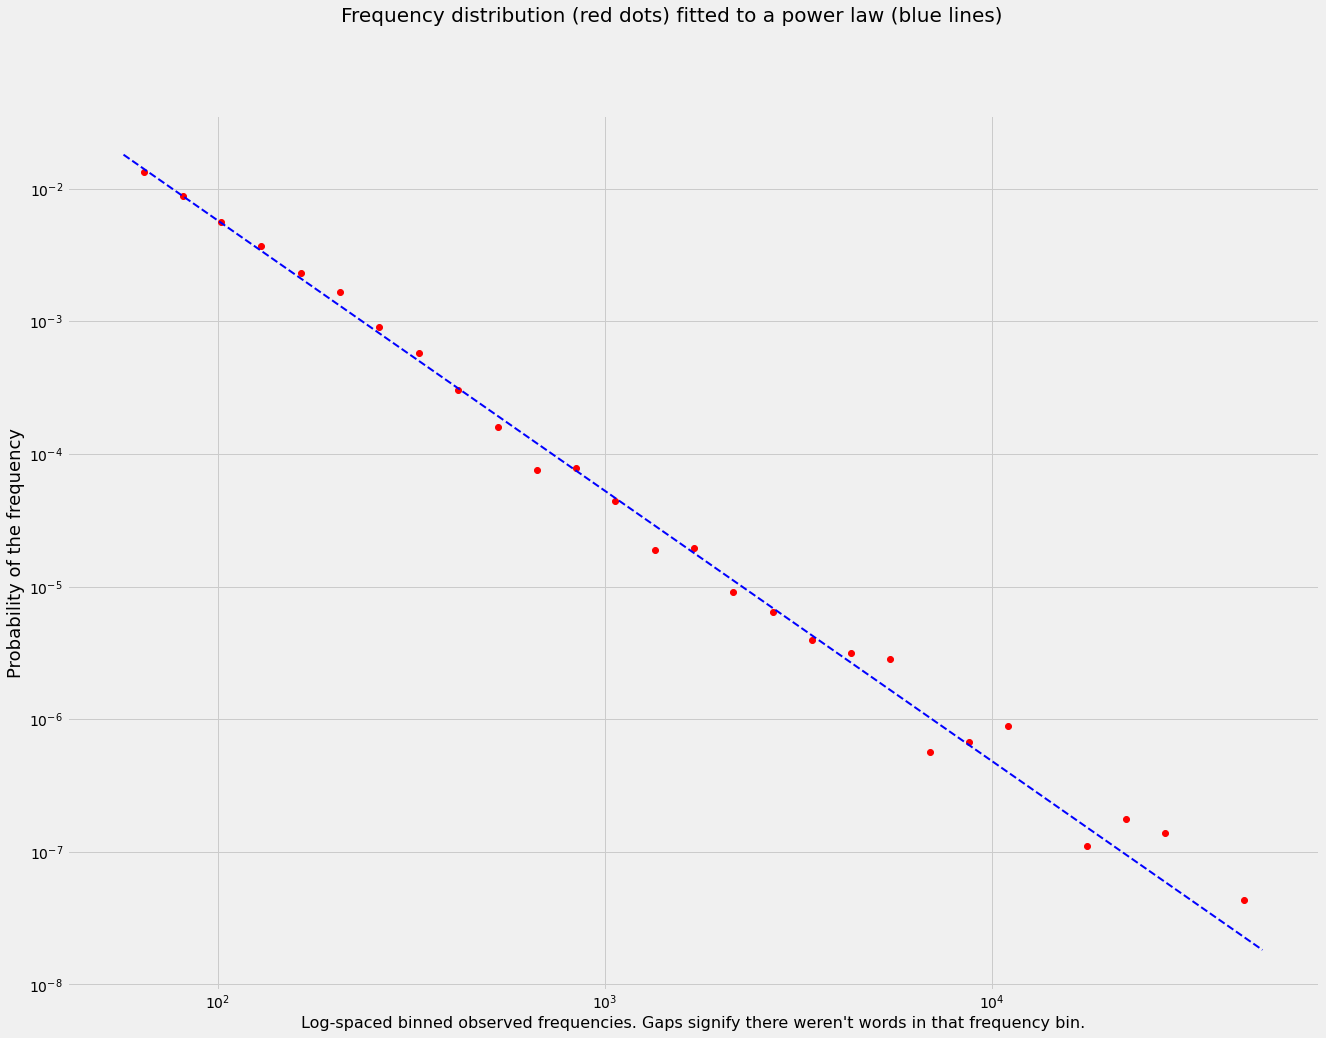

In [11]:
# Graph it out.
fig = plt.figure(figsize=(20,15))
# The pdf of the observed data. 
# The continuous line is superfluous and confusing I think (?) Hacky removing.
fit.plot_pdf(color='r', linewidth=0, linestyle=':', marker='o')
# The pdf of the best fit powerlaw
fit.power_law.plot_pdf(color='b', linestyle='--', linewidth=2)
fig.suptitle('Frequency distribution (red dots) fitted to a power law (blue lines)', fontsize=20)
plt.ylabel('Probability of the frequency', fontsize=18)
plt.xlabel('Log-spaced binned observed frequencies. Gaps signify there weren\'t words in that frequency bin.', fontsize=16)

In [12]:
def plot_zipf(observed, predicted_x, predicted_y, alpha=1, multiplier=1):
    """
    This function plots the correspondence of the distribution of terms
    generated by count_vocab_frequencies with the projected Zipf's law
    distribution.
    """
    num_tokens = len(observed)
    max_rank = 50
    y_bins = np.arange(max_rank)
    smaller_predicted_x = predicted_x[predicted_x <= max_rank]
    plt.figure(figsize=(10,10))
    plt.bar(y_bins, observed[:max_rank]*multiplier, align='center', alpha=0.5)
    plt.plot(smaller_predicted_x, predicted_y[:len(smaller_predicted_x)]*multiplier, color='r', linestyle='--',linewidth=2,alpha=0.5)
    plt.ylabel('Probability')
    plt.xlabel('Bin')
    plt.title("Top %s ranks in the dataset, with predictions from a fitted power law in dotted red" % max_rank)

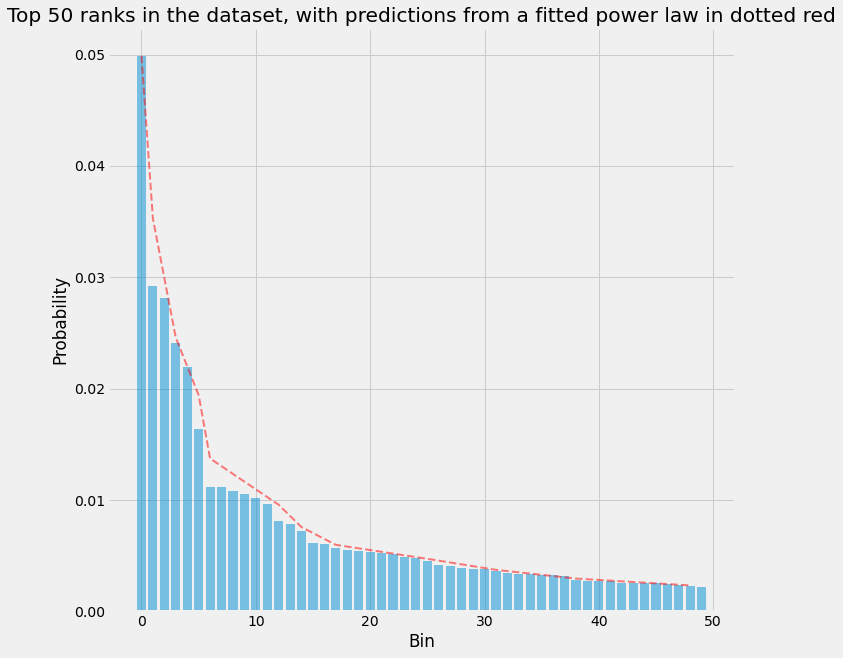

In [13]:
# Clean this up so you're not making these calculations here.
plot_zipf(np.array(observed_counts)/norm, np.array(predicted_x_axis), np.array(predicted_y_axis)/norm, alpha=alpha)

#### Check fit to other distributions.
#### This is comparing the log likelihood ratio of the power law distribution to alternative distributions: a truncated power law, an exponential distribution or a lognormal distribution.
#### NB: There's an issue here with handling correlations.
#### I'm not sure this is the best way to do this, esp bc it throws errors.


In [14]:
print("Checking log likelihood ratio to see if the data is better explained")
print("by other well-behaved distributions...")
# The first value returned from distribution_compare is the log likelihood ratio
better_distro = False
trunc = fit.distribution_compare('power_law', 'truncated_power_law')
if trunc[0] < 0:
    print("Seems a truncated power law is a better fit.")
    better_distro = True

lognormal = fit.distribution_compare('power_law', 'lognormal')
if lognormal[0] < 0:
    print("Seems a lognormal distribution is a better fit.")
    print("But don't panic -- that happens sometimes with language.")
    better_distro = True
    
exponential = fit.distribution_compare('power_law', 'exponential')
if exponential[0] < 0:
    print("Seems an exponential distribution is a better fit. Panic.")
    better_distro = True
    
if not better_distro:
    print("\nSeems your data is best fit by a power law. Celebrate!!")

Checking log likelihood ratio to see if the data is better explained
by other well-behaved distributions...


Assuming nested distributions



Seems your data is best fit by a power law. Celebrate!!
